In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import itertools
from collections import Counter
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

%matplotlib inline

In [2]:
class RBM(nn.Module):
    def __init__(self, n_v, n_h):
        super(RBM, self).__init__()
        self.n_v = n_v
        self.n_h = n_h
        self.b_v = nn.Parameter(torch.randn(1, n_v))
        self.b_h = nn.Parameter(torch.randn(1, n_h))
        self.W = nn.Parameter(torch.randn(n_h, n_v))
        
        
    def v_to_h(self, v):
        if v.dim() == 1:
            v = v.unsqueeze(0)
        p = torch.sigmoid(F.linear(v, self.W, self.b_h))
        return torch.bernoulli(p)
    
    def h_to_v(self, h):
        if h.dim() == 1:
            h = h.unsqueeze(0)
        p = torch.sigmoid(F.linear(h, self.W.t(), self.b_v))
        return torch.bernoulli(p)
    
    def forward(self, v):
        h = self.v_to_h(v)
        v = self.h_to_v(h)
        return v
    
    def energy(self, v, h):
        if h.dim() == 1:
            h = h.unsqueeze(0)
        if v.dim() == 1:
            v = v.unsqueeze(0)
        vbias_term = torch.matmul(v, self.b_v.t())
        hbias_term = torch.matmul(h, self.b_h.t())
        weight_term = torch.matmul(torch.matmul(v, self.W.t()), h.t())
        return -(vbias_term + hbias_term + weight_term)
                
    def P_vl_1_given_h(self, h, l):
    # Ensure h is a 2D tensor with shape [1, n_h]
        if h.dim() == 1:
            h = h.unsqueeze(0)
        weight = self.W[:, l].unsqueeze(0)
        return torch.sigmoid(F.linear(h, weight.t(), self.b_v[0,l]))
    
    def P_hl_1_given_v(self, v, l):
        if v.dim() == 1:
            v = v.unsqueeze(0)
        weight = self.W[l,:].unsqueeze(0)
        return torch.sigmoid(F.linear(v, weight, self.b_h[0,l]))
    
    def P_h_1_given_v(self, v):
        p_h_1_given_v = torch.zeros(self.n_h, 1)

        for i in range(self.n_h):
            p_h_1_given_v[i, 0] = self.P_hl_1_given_v(v, i)

        return p_h_1_given_v
    
    def Gibbs_sampler(self, N, Burn_N):
        total_samples = N + Burn_N  # Total samples including burn-in
        samples = torch.empty((total_samples, self.n_v))

        # Initial sample
        sample_init = torch.bernoulli(torch.full((self.n_v,), 0.5))
        samples[0] = sample_init

        # Generate samples
        for i in range(total_samples - 1):
            samples[i + 1] = self.forward(samples[i])

        # Discard the first Burn_N samples
        return samples[Burn_N:]

In [3]:
def softplus(a):
    return np.log(1+np.exp(a))

def free_energy(x, y, w, u, c, d):
    return -d[:,y] - np.sum(softplus(np.transpose(c+u[:,y]+np.matmul(w,np.transpose(x)))))

def class_probability(x, y, C, w, u, c, d):
    free_energies = [-free_energy(x, j, w, u, c, d) for j in C]
    free_energy_y = -free_energy(x, y, w, u, c, d)
    de = 0
    for fe in free_energies:
        de+=np.exp(fe-free_energy_y)
    return 1/de

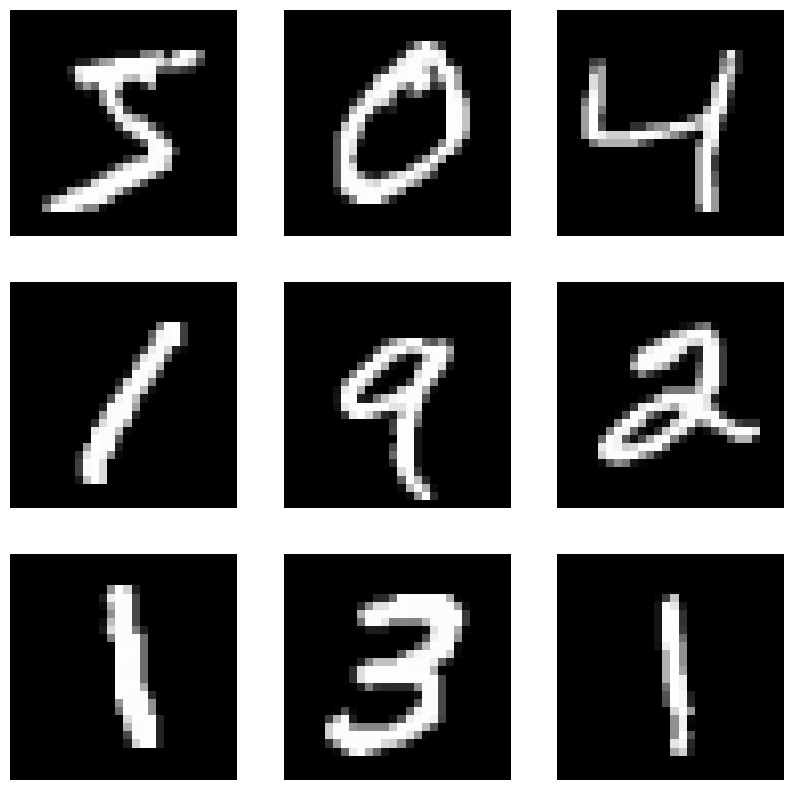

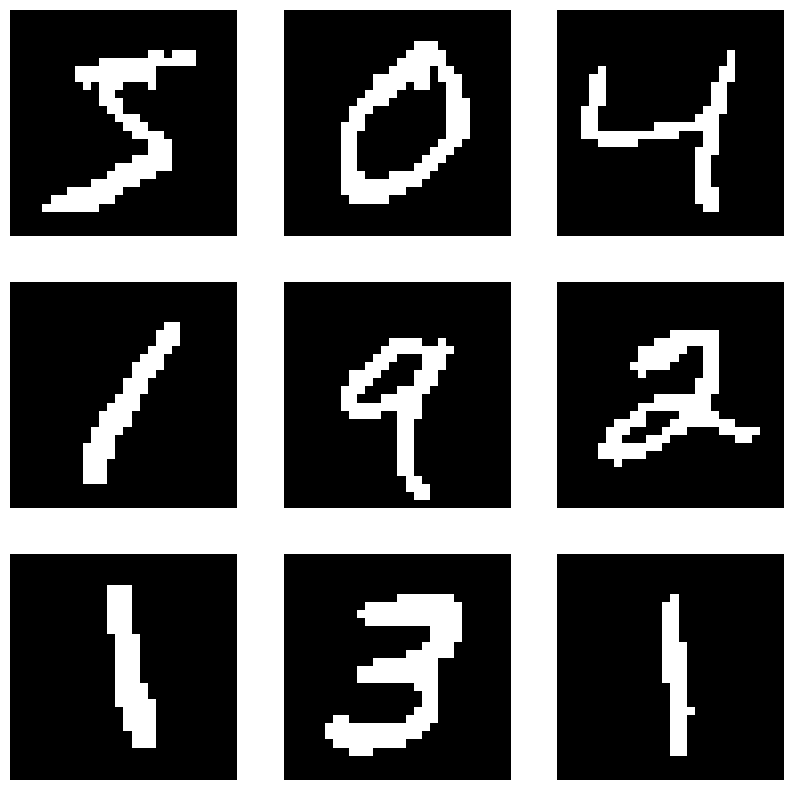

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

In [4]:
import tempfile
temp_dir = tempfile.gettempdir()
def show_mnist_images(dataset, num_images=9):
    # Create a PyTorch DataLoader
    loader = torch.utils.data.DataLoader(dataset, batch_size=num_images)
    
    # Get a batch of images
    dataiter = iter(loader)
    images, labels = next(dataiter)  # Use next() function

    # Convert images to numpy for display
    images = images.numpy()

    # Plot images
    fig, axes = plt.subplots(int(num_images**0.5), int(num_images**0.5), figsize=(10, 10))
    axes = axes.flatten()
    for img, ax in zip(images, axes):
        ax.imshow(img.squeeze(), cmap='gray')  # Squeeze to remove channel dimension
        ax.axis('off')
    plt.show()

def show_mnist_images_binary(dataset, num_images=9):
    # Create a PyTorch DataLoader
    loader = torch.utils.data.DataLoader(dataset, batch_size=num_images)
    
    # Get a batch of images
    dataiter = iter(loader)
    images, labels = next(dataiter)  # Use next() function

    # Convert images to numpy for display
    images = images.numpy()
    threshold = 0.5
    images = (images > threshold).astype(int)

    # Plot images
    fig, axes = plt.subplots(int(num_images**0.5), int(num_images**0.5), figsize=(10, 10))
    axes = axes.flatten()
    for img, ax in zip(images, axes):
        ax.imshow(img.squeeze(), cmap='gray')  # Squeeze to remove channel dimension
        ax.axis('off')
    plt.show()
# Load MNIST dataset
mnist_train = datasets.MNIST(root=temp_dir, train=True, download=True, transform=transforms.ToTensor())

# Call the function with the dataset
show_mnist_images(mnist_train, num_images=9)
show_mnist_images_binary(mnist_train, num_images=9)
print(mnist_train[0])


In [5]:
from torch.utils.data import DataLoader, Dataset

def one_hot_encode(labels, num_classes=10):
    return torch.eye(num_classes)[labels]

class MNISTDataset(Dataset):
    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset

    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, idx):
        image, label = self.mnist_dataset[idx]
        # Flatten the image to 1x784
        image = image.view(-1)
        # One-hot encode the label to 1x10
        label_one_hot = one_hot_encode(torch.tensor(label))
        # Concatenate image and label
        image_label = torch.cat((image, label_one_hot))
        return image_label, label

# Create custom dataset
mnist_dataset = MNISTDataset(mnist_train)

# DataLoader for batching - Example usage
train_loader = DataLoader(mnist_dataset, shuffle=True)

# Initialize empty tensors for data and target
data = torch.empty(0, 794)  # For the concatenated image and one-hot encoded label
target = torch.empty(0, 1, dtype=torch.long)  # For the actual label

n_data = 200
# Iterate over the train_loader to get the first 100 samples
for i, (image_label, label) in enumerate(train_loader):
    if i == n_data:
        break
    data = torch.cat((data, image_label), dim=0)
    target = torch.cat((target, label.view(-1, 1)), dim=0)
    
threshold = 0.5
data = (data > threshold).type(torch.int)

print(data[0])

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,

In [6]:
print(len(data))

200


In [7]:
class MNISTTestDataset(Dataset):
    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset

    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, idx):
        image, label = self.mnist_dataset[idx]
        # Flatten the image to 784x1
        image = image.view(-1)
        return image, label


# Load MNIST test dataset
mnist_test = datasets.MNIST(root=temp_dir, train=False, download=True, transform=transforms.ToTensor())

# Create custom dataset for test data
mnist_test_dataset = MNISTTestDataset(mnist_test)

# DataLoader for batching - Example usage
test_loader = DataLoader(mnist_test_dataset, shuffle=True)

# Initialize empty tensors for data and target
data_test = torch.empty(0, 784)
target_test = torch.empty(0, 1, dtype=torch.long)

# Iterate over the train_loader to get the first 100 samples
for i, (image_label, label) in enumerate(test_loader):
    if i == n_data:
        break
    data_test = torch.cat((data_test, image_label), dim=0)
    target_test = torch.cat((target_test, label.view(-1, 1)), dim=0)

data_test = (data_test > threshold).type(torch.int)



In [12]:
v_size = 794
h_size = 500

rbm = RBM(v_size, h_size)


In [13]:
epoch = 1000
lr = 0.1
n_data = len(data)
#min_true_loss = float('inf')  # Initialize minimum true loss to infinity
accuracy_set = []
accuracy_set_test = []

for k in range(epoch):
    g_W = torch.randn(h_size, v_size)
    g_b_v = torch.randn(1, v_size)
    g_b_h = torch.randn(1, h_size)
    
    n_w = 2000
    burn = 1000
    sector_2_sample = rbm.Gibbs_sampler(n_w,burn)
    sector_3_sample = torch.empty((n_w, rbm.n_h))
    sector_1 = 0
    sector_2 = 0
    sector_3 = 0
    for vv in range(n_w):
        sector_3_sample[vv] = rbm.v_to_h(sector_2_sample[vv])
        sector_3_sample_reshaped = sector_3_sample[vv].view(rbm.n_h, 1)  # Reshape to 3x1
        sector_2_sample_reshaped = sector_2_sample[vv].view(1, rbm.n_v)  # Reshape to 1x4
    
        sector_1 = sector_1 + 1/n_w * torch.matmul(sector_3_sample_reshaped, sector_2_sample_reshaped)
        sector_2 = sector_2 + 1/n_w * sector_2_sample[vv]
        sector_3 = sector_3 + 1/n_w * sector_3_sample[vv]
 
    
    for l in range(n_data):
        v = torch.tensor(data[l,:], dtype=torch.float32)
        v = v.unsqueeze(0)
        h = rbm.v_to_h(v)
         
        g_W += torch.matmul(rbm.P_h_1_given_v(v), v)/n_data
        g_b_v += v/n_data
        g_b_h += rbm.P_h_1_given_v(v).t()/n_data
        
    g_W -= sector_1
    g_b_v -= sector_2
    g_b_h -= sector_3
    
    rbm.W = nn.Parameter(rbm.W + lr * g_W)
    rbm.b_v = nn.Parameter(rbm.b_v + lr * g_b_v)
    rbm.b_h = nn.Parameter(rbm.b_h + lr * g_b_h)
    
    W = rbm.W.detach().numpy()
    bias_v = rbm.b_v.detach().numpy()
    bias_h = rbm.b_h.detach().numpy()

    data_shape = 784
    clas = 0,1,2,3,4,5,6,7,8,9
    n_class = len(clas)

    w = W[:,0:data_shape]
    u = W[:,data_shape:data_shape+n_class+1]
    b = bias_v[:,0:data_shape]
    c = bias_h
    d = bias_v[:,data_shape:data_shape+n_class+1]
    
    correct_predictions = 0
    for i in range(len(data)):
        # Compute the free energy for each class
        free_energies = [-free_energy(data[i].detach().numpy()[0:784], j, w, u, c, d) for j in clas]
        # Get the index of the maximum free energy
        max_free_energy_index = np.argmax(free_energies)
        # Get the predicted class
        predict_class = clas[max_free_energy_index]
        # Get the actual class
        actual_class = int(target[i].detach().numpy())
        # Increment the count for correct predictions
        if actual_class == predict_class:
            correct_predictions += 1

    # Calculate accuracy as the proportion of correct predictions
    accuracy = correct_predictions / len(data)
    #print(f"Epoch {k}: Train accuracy = {accuracy}")
    accuracy_set.append(accuracy)
    
    correct_predictions = 0
    for i in range(len(data_test)):
        # Compute the free energy for each class
        free_energies = [-free_energy(data_test[i].detach().numpy()[0:784], j, w, u, c, d) for j in clas]
        # Get the index of the maximum free energy
        max_free_energy_index = np.argmax(free_energies)
        # Get the predicted class
        predict_class = clas[max_free_energy_index]
        # Get the actual class
        actual_class = int(target_test[i].detach().numpy())
        # Increment the count for correct predictions
        if actual_class == predict_class:
            correct_predictions += 1

    # Calculate accuracy as the proportion of correct predictions
    accuracy = correct_predictions / len(data_test)
    #print(f"Epoch {k}: Test accuracy = {accuracy}")
    accuracy_set_test.append(accuracy)
    if ((k+1)%50==0):
        print(f'epoch {k+1}')

/var/folders/3n/sd9mh6rx2h5byl5f0955mv840000gn/T/ipykernel_3833/350859298.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v = torch.tensor(data[l,:], dtype=torch.float32)


epoch 50
epoch 100
epoch 150
epoch 200
epoch 250
epoch 300
epoch 350
epoch 400
epoch 450
epoch 500
epoch 550
epoch 600
epoch 650
epoch 700
epoch 750
epoch 800
epoch 850
epoch 900
epoch 950
epoch 1000


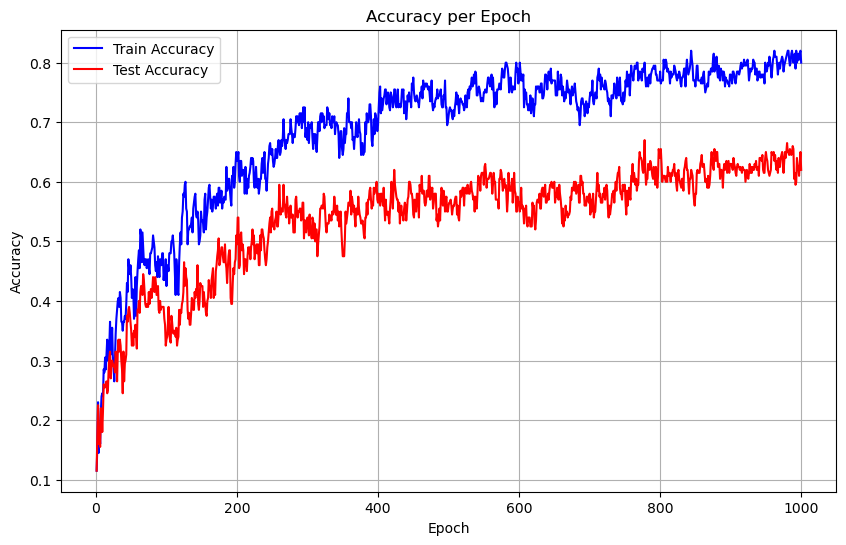

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, epoch + 1), accuracy_set, label = 'Train Accuracy', color='blue')
plt.plot(range(1, epoch + 1), accuracy_set_test, label = 'Test Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.xscale("log")
#plt.yscale("log")
plt.title('Accuracy per Epoch')
plt.legend()
plt.grid(True)
plt.show()

In [104]:
W = rbm.W.detach().numpy()
bias_v = rbm.b_v.detach().numpy()
bias_h = rbm.b_h.detach().numpy()

data_shape = 784
clas = 0,1,2,3,4,5,6,7,8,9
n_class = len(clas)

w = W[:,0:data_shape]
u = W[:,data_shape:data_shape+n_class+1]
b = bias_v[:,0:data_shape]
c = bias_h
d = bias_v[:,data_shape:data_shape+n_class+1]

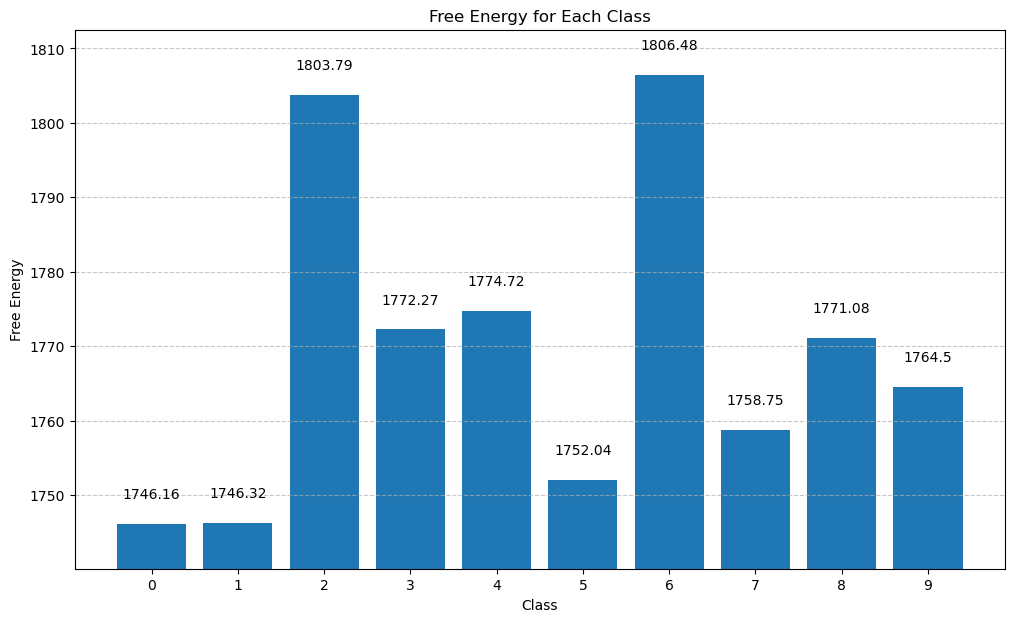

In [90]:
clas = [i.item() if hasattr(i, "item") else i for i in clas]

# Assuming the free_energy function and other variables (data_test, w, u, c, d) are already defined
free_energies = [-free_energy(data_test[0].detach().numpy(), i, w, u, c, d).item() for i in clas]

# Find the range of free energy values for setting Y-axis limits
min_energy = min(free_energies)
max_energy = max(free_energies)
energy_range = max_energy - min_energy

# Plotting
plt.figure(figsize=(12, 7))
bars = plt.bar(clas, free_energies)

# Adding data labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05 * energy_range, round(yval, 2), ha='center', va='bottom')

plt.title("Free Energy for Each Class")
plt.xlabel("Class")
plt.ylabel("Free Energy")
plt.xticks(clas)
plt.ylim(min_energy - 0.1 * energy_range, max_energy + 0.1 * energy_range)  # Adjust Y-axis limits
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid lines for better readability
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


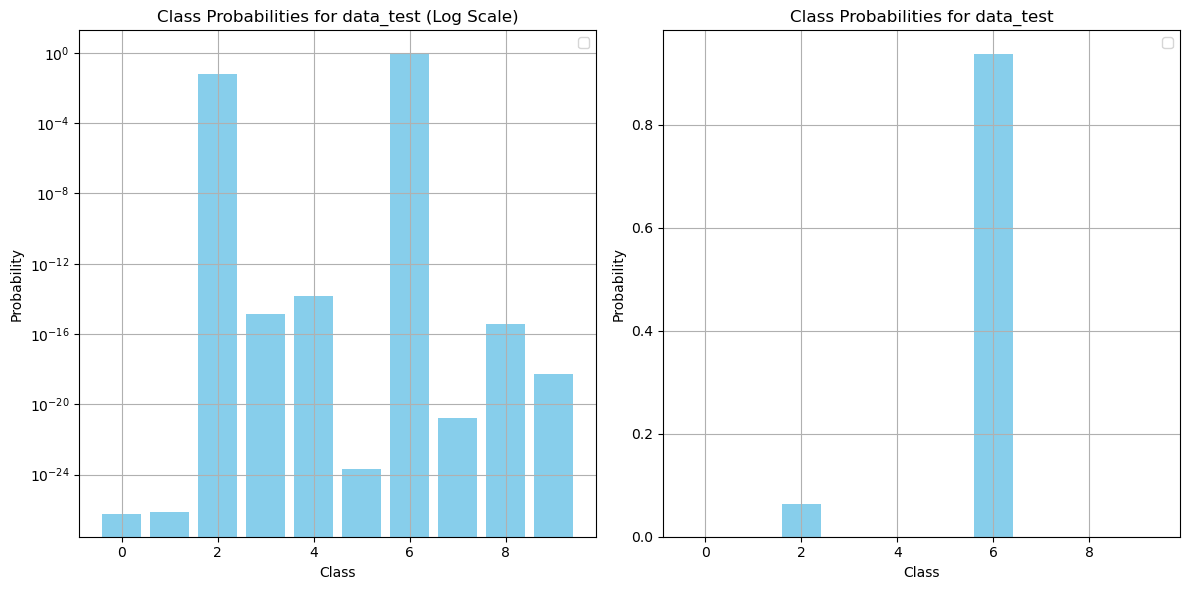

In [94]:
probabilities = [class_probability(data_test[0].detach().numpy()[0:784], i, clas, w, u, c, d).item() for i in clas]
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# First subplot with log scale for both axes
axs[0].bar(clas, probabilities, color='skyblue')
axs[0].set_xlabel('Class')
axs[0].set_ylabel('Probability')
axs[0].set_yscale('log')
axs[0].set_title('Class Probabilities for data_test (Log Scale)')
axs[0].legend()
axs[0].grid(True)

# Second subplot with linear scale (default)
axs[1].bar(clas, probabilities, color='skyblue')
axs[1].set_xlabel('Class')
axs[1].set_ylabel('Probability')
axs[1].set_title('Class Probabilities for data_test')
axs[1].legend()
axs[1].grid(True)

# Display the plot
plt.tight_layout()  # Adjust subplots to fit into the figure area.
plt.show()

In [95]:
print(class_probability(data_test[n_data-1].detach().numpy(), 9, clas, w, u, c, d))

[0.]


/var/folders/3n/sd9mh6rx2h5byl5f0955mv840000gn/T/ipykernel_773/563207747.py:12: RuntimeWarning: overflow encountered in exp
  de+=np.exp(fe-free_energy_y)


In [53]:
count = 0
count = [0,0,0,0,0,0,0,0,0,0]
for i in range(len(data_test)):
    free_energies = [-free_energy(data_test[i].detach().numpy(), j, w, u, c, d) for j in clas]
    max_free_energy_index = np.argmax(free_energies)
    predict_class = clas[max_free_energy_index]
    actual_class = int(target_test[i].detach().numpy())
    if int(target_test[i].detach().numpy()) == predict_class:
        count += 1/n_data
print(count)

0.6200000000000004


In [60]:
count = [0,0,0,0,0,0,0,0,0,0]
total = [0,0,0,0,0,0,0,0,0,0]
for i in range(len(data_test)):
    free_energies = [-free_energy(data_test[i].detach().numpy(), j, w, u, c, d) for j in clas]
    max_free_energy_index = np.argmax(free_energies)
    predict_class = clas[max_free_energy_index]
    actual_class = int(target_test[i].detach().numpy())
    total[actual_class] += 1
    if int(target_test[i].detach().numpy()) == predict_class:
        count[actual_class] += 1
print(total)


[20, 30, 20, 24, 13, 19, 13, 25, 17, 19]


In [59]:
count = np.zeros((10, 10))
total = [0,0,0,0,0,0,0,0,0,0]
for i in range(len(data_test)):
    free_energies = [-free_energy(data_test[i].detach().numpy(), j, w, u, c, d) for j in clas]
    max_free_energy_index = np.argmax(free_energies)
    predict_class = clas[max_free_energy_index]
    actual_class = int(target_test[i].detach().numpy())
    count[actual_class, predict_class] += 1
    total[actual_class] += 1
    
print(count)

[[11.  0.  0.  0.  0.  5.  2.  1.  0.  1.]
 [ 0. 30.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 2.  1. 15.  0.  0.  0.  2.  0.  0.  0.]
 [ 1.  1.  2.  8.  1.  6.  1.  2.  2.  0.]
 [ 0.  0.  0.  0.  6.  0.  3.  1.  0.  3.]
 [ 2.  2.  1.  1.  0.  4.  1.  0.  5.  3.]
 [ 0.  1.  0.  0.  0.  0. 11.  0.  1.  0.]
 [ 1.  0.  1.  0.  0.  1.  0. 18.  1.  3.]
 [ 1.  1.  1.  0.  0.  4.  1.  0.  9.  0.]
 [ 0.  2.  0.  0.  0.  0.  3.  2.  0. 12.]]


In [ ]:
count = np.zeros((10, 10))
total = [0,0,0,0,0,0,0,0,0,0]

# Assuming you have a list called data_test and other necessary variables defined
for i in range(len(data_test)):
    free_energies = [-free_energy(data_test[i].detach().numpy(), j, w, u, c, d) for j in clas]
    max_free_energy_index = np.argmax(free_energies)
    predict_class = clas[max_free_energy_index]
    actual_class = int(target_test[i].detach().numpy())
    count[actual_class, predict_class] += 1
    total[actual_class] += 1

# Convert total to a NumPy array for broadcasting
total_array = np.array(total).reshape(-1, 1)  # Reshape for compatibility with count's rows

# Divide each row in count by the corresponding total value
# To ensure no division by zero, replace zeros in total_array with 1 temporarily for the division
safe_total = np.where(total_array == 0, 1, total_array)
normalized_count = count / safe_total
print(normalized_count)

In [106]:
count = 0
for i in range(len(data)):
    free_energies = [-free_energy(data[i].detach().numpy()[0:784], j, w, u, c, d) for j in clas]
    max_free_energy_index = np.argmax(free_energies)
    predict_class = clas[max_free_energy_index]
    actual_class = int(target[i].detach().numpy())
    if actual_class == predict_class:
        count += 1/n_data
print(count)

0.43000000000000027


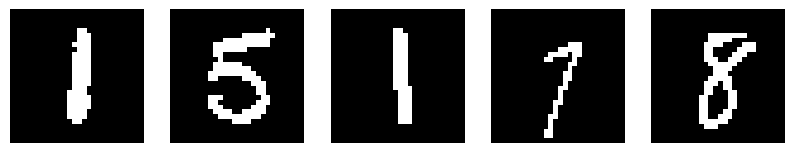

In [48]:
n_images = 5

fig, axes = plt.subplots(1, n_images, figsize=(10, 2))  # Creates a figure with 5 subplots
for i in range(n_images):
    img = data_test[-i-1].reshape(28, 28)  # Reshape each image to 28x28
    axes[i].imshow(img, cmap='gray')  # Plot each image in grayscale
    axes[i].axis('off')  # Turn off axis to make it look cleaner

plt.show()


In [49]:
def predict(image_number):
    for i in range(image_number):
        free_energies = [-free_energy(data_test[-i-1].detach().numpy()[0:784], j, w, u, c, d) for j in clas]
        max_free_energy_index = np.argmax(free_energies)
        print(max_free_energy_index)
predict(5)

1
9
1
7
8


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


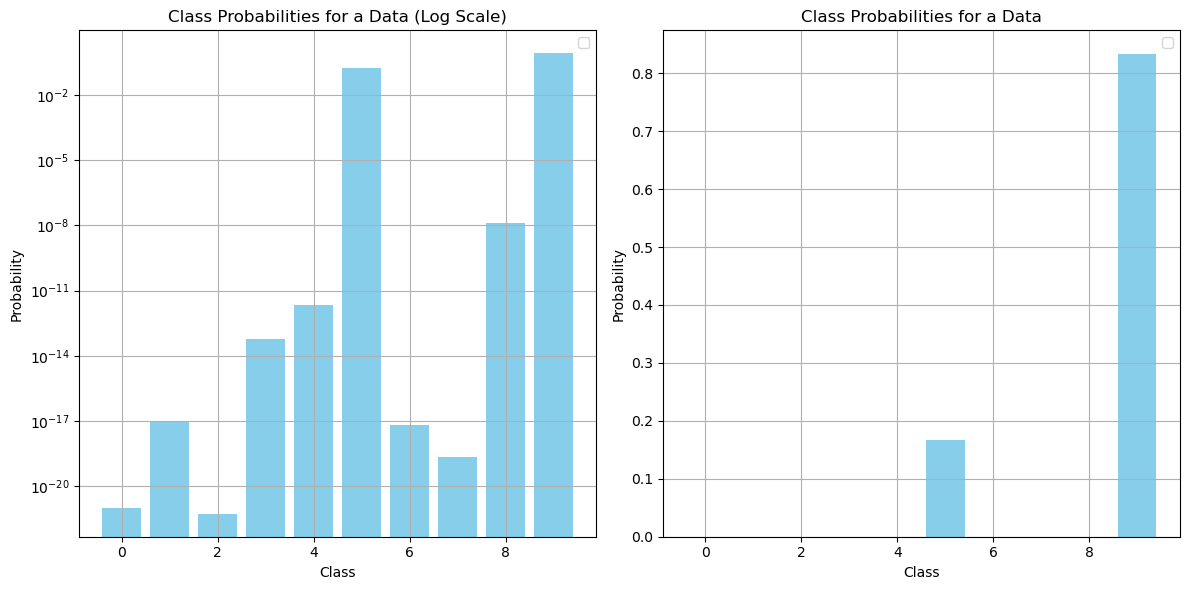

In [52]:
probabilities = [class_probability(data_test[-2].detach().numpy()[0:784], i, clas, w, u, c, d).item() for i in clas]
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# First subplot with log scale for both axes
axs[0].bar(clas, probabilities, color='skyblue')
axs[0].set_xlabel('Class')
axs[0].set_ylabel('Probability')
axs[0].set_yscale('log')
axs[0].set_title('Class Probabilities for a Data (Log Scale)')
axs[0].legend()
axs[0].grid(True)

# Second subplot with linear scale (default)
axs[1].bar(clas, probabilities, color='skyblue')
axs[1].set_xlabel('Class')
axs[1].set_ylabel('Probability')
axs[1].set_title('Class Probabilities for a Data')
axs[1].legend()
axs[1].grid(True)

# Display the plot
plt.tight_layout()  # Adjust subplots to fit into the figure area.
plt.show()